In [1]:
from code_file.imports_and_libraries import *
from code_file.dataset_creation import *
from code_file.positional_encodings import *
from code_file.models import *
from code_file.train_and_test import *
from code_file.visualizations import *

In [9]:
def make_double_sine_dataset(N: int=cfg.num_of_samples, t_interval: list=cfg.time_interval, t_k: int=cfg.discr_of_time, w_min: float=cfg.omega_min, w_max: float=cfg.omega_max, 
                      seed=cfg.seed, mu: float=cfg.mu, sigma: float=cfg.noise_std, noise: bool=False):
    '''
    Generate a dataset with N samples of sine waves y=sin(wi*t) + sin(wj*t) with frequencies w sampled uniformly from [w_min, w_max] - both limit values are included.
    Optionally, Gaussian noise N(mu, sigma) can be added to each sample.

    Returns: tuple of NumPy arrays (V, target, t_val)
    '''

    rng = np.random.default_rng(seed)

    #evenly space time in t_k levels
    t_val = np.linspace(t_interval[0], t_interval[1], t_k)
    #generate N frequencies from [w_min ,w_max] for two mix omegas
    w_val = rng.uniform(w_min, w_max, size=(N,2))
    
    V, target = [], []

    #generate N samples of sin(wi*t) + sin(wj*t)
    for w1, w2 in w_val:
        if noise:
            Vi = 1 * np.sin(w1 * t_val) + 1 * np.sin(w2 * t_val) + rng.normal(mu, sigma, size=t_k)
        else:
            Vi = 1 * np.sin(w1 * t_val) + 1 * np.sin(w2 * t_val)
        V.append(np.array(Vi))
        
        #target.append(np.sort([w1,w2]))
        target.append(np.array([w1,w2]))
    #return tuple of arrays of 
    return np.array(V), np.array(target), t_val

In [10]:
class HeadWithFlow2(nn.Module):
    '''Normalizing flow head for omegas - now mixture of 3.'''

    def __init__(self, context_dim: int, hidden_features: int=cfg.flow_hidden_features, num_layers: int=cfg.flow_num_layers, out_dim: int = 2,):
        super().__init__()

        self.context_dim  = context_dim
        self.hidden_features = hidden_features
        self.num_layers = num_layers
        self.out_dim = out_dim
        self.context_net = nn.Linear(context_dim, hidden_features)

        #MAF - creating matrixes which will transform distribution
        transform_list = []
        for _ in range(num_layers):
            transform_list.append(transforms.MaskedAffineAutoregressiveTransform(features=out_dim , hidden_features=hidden_features, context_features=hidden_features))

        #chaining transformation sequence
        transform = transforms.CompositeTransform(transform_list)

        #wraps flow as object and keeps the information
        base_dist = distributions.StandardNormal(shape=[out_dim])
        self.flow = flows.Flow(transform=transform, distribution=base_dist)

    def encode_context_head(self, context):
        return self.context_net(context)

    def log_prob(self, omega, context):
        ctx = self.encode_context_head(context)
        log_p = self.flow.log_prob(inputs=omega, context=ctx)
        return log_p

    def sample(self, context, num_samples: int):
        #function gives out mean, uncertainity and shape of distribution
        ctx = self.encode_context_head(context)  
    
        samples = self.flow.sample(num_samples=num_samples, context=ctx)
        return samples
    



class TransformerModel3(nn.Module):
    '''Normalizing-flow head.
        - forward(x) returns the mean of samples
        - log_prob(x, y) for training with NLL
        - sample(x, S) for uncertainty (S samples)'''

    def __init__(self, seq_len: int=cfg.discr_of_time, d_model: int=cfg.dmodel, nhead: int=cfg.nhead, num_layers: int=cfg.num_layers,
                 dim_f: int=cfg.dim_f, dropout: float=cfg.dropout, flow_hidden_features: int=cfg.flow_hidden_features, flow_num_layers: int=cfg.flow_num_layers,
                 out_dim: int=2):

        super().__init__()

        self.input_embedding = nn.Linear(1, d_model)
        self.position_encoding = PositionalEncoding(d_model, seq_len)

        layer = nn.TransformerEncoderLayer(d_model, nhead, dim_f, dropout=dropout, batch_first=True)        #creates layers/blocks
        self.transformer_encoder = nn.TransformerEncoder(layer, num_layers)

        self.pre_head_norm = nn.LayerNorm(d_model)

        #flowhead
        self.flow_head = HeadWithFlow2(context_dim=d_model, hidden_features=flow_hidden_features, num_layers=flow_num_layers, out_dim=out_dim)


    def forward(self, src):
        '''Forward pass'''

        src = src.unsqueeze(-1)

        src = self.input_embedding(src)
        src = self.position_encoding(src)
        z = self.transformer_encoder(src)

        pool = z.mean(dim=1)
        head_norm = self.pre_head_norm(pool)
        
        with torch.no_grad():
            samples = self.flow_head.sample(head_norm, num_samples=20)
        mu = samples.mean(dim=1)
        return mu

    # def log_prob(self, src, target):
    #     src = src.unsqueeze(-1)

    #     src = self.input_embedding(src)
    #     src = self.position_encoding(src)
    #     z = self.transformer_encoder(src)

    #     pool = z.mean(dim=1)
    #     head_norm = self.pre_head_norm(pool)
        
    #     log_p = self.flow_head.log_prob(target, context=head_norm)
    #     return log_p

    def log_prob(self, src, target):
        """
        Permutation-invariant log p({w1, w2} | x).

        src    : (B, T)
        target : (B, 2)  -- unordered pair [w1, w2] from dataset
        """
        # standard encoder pass
        src = src.unsqueeze(-1)
        src = self.input_embedding(src)
        src = self.position_encoding(src)
        z = self.transformer_encoder(src)

        pool = z.mean(dim=1)
        head_norm = self.pre_head_norm(pool)

        # 1) original order (w1, w2)
        log_p1 = self.flow_head.log_prob(target, context=head_norm)

        # 2) swapped order (w2, w1)
        log_p2 = self.flow_head.log_prob(target.flip(dims=[1]), context=head_norm)

        # symmetric mixture: p_sym = 0.5 * (p(w1,w2) + p(w2,w1))
        log_p_sym = torch.logsumexp(torch.stack([log_p1, log_p2], dim=1) , dim=1) - math.log(2.0)

        return log_p_sym

    def sample(self, src, num_samples: int = 100):
        src = src.unsqueeze(-1)

        src = self.input_embedding(src)
        src = self.position_encoding(src)
        z = self.transformer_encoder(src)

        pool = z.mean(dim=1)
        head_norm = self.pre_head_norm(pool) 
        
        samples = self.flow_head.sample(head_norm, num_samples)
        return samples


In [11]:
@torch.no_grad()
def prediction_collecter_omegas(loader, model, device):
    """
    Collect true and predicted omegas (w_low, w_high) for plotting.

    Returns:
        y_true_omega : (N, 2)
        y_pred_omega : (N, 2)
    """
    model.eval()
    y_true_list, y_pred_list = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)  # yb: (B,2) = [w_low, w_high]

        pred_omegas = model(xb)                # (B,2)
        # Just in case, sort both; but if training targets were sorted,
        # model should learn the order by itself.
        true_sorted, _ = torch.sort(yb, dim=1)
        pred_sorted, _ = torch.sort(pred_omegas, dim=1)

        y_true_list.append(true_sorted.cpu())
        y_pred_list.append(pred_sorted.cpu())

    y_true = torch.cat(y_true_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y_true, y_pred


@torch.no_grad()
def evaluate(loader, model, device):
    model.eval()
    mse, mae, n = 0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)                     # (B,2) unordered

        pred_sorted, _ = torch.sort(pred, dim=1)
        true_sorted, _ = torch.sort(yb, dim=1)

        diff = pred_sorted - true_sorted

        mse += torch.sum(diff * diff).item()
        mae += torch.sum(torch.abs(diff)).item()
        n += yb.numel()
    
    return mse / n, mae / n


def train_and_eval_training_flow(train_loader, val_loader, device, model, optimizer, scheduler, 
                            max_epochs: int=cfg.epochs, print_update: bool=False):
    '''Train the model and evaluate on validation. Saves best model based on validation MSE through training but with NLL loss function'''

    #real loop and training and everything....
    best_val = float("inf")
    best_state = None

    train_mse_hist, val_mse_hist = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        
        #training step
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            #NLL loss function
            log_p = model.log_prob(xb, yb)
            loss = -log_p.mean()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()

        tr_mse, tr_mae = evaluate(train_loader, model, device)
        val_mse, val_mae = evaluate(val_loader, model, device)

        train_mse_hist.append(tr_mse)
        val_mse_hist.append(val_mse)

        #validation steo
        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if print_update:
            if epoch % 10 == 0:
                tr_mse, tr_mae = evaluate(train_loader, model, device)
                print(f"Epoch {epoch:3d}; Train MSE {tr_mse:.6f}, MAE {tr_mae:.6f}; Val MSE {val_mse:.6f}, MAE {val_mae:.6f}")

    #load the best weights
    model.load_state_dict(best_state)

    return model, train_mse_hist, val_mse_hist



In [12]:
def plot_pred_vs_true_omega(
    y_true_omega,
    y_pred_omega,
    test_mse,
    test_mae,
    N: int = cfg.num_of_samples,
    t_disc: int = cfg.discr_of_time,
    w_min: float = cfg.omega_min,
    w_max: float = cfg.omega_max,
    seed=cfg.seed,
    sigma: float = cfg.noise_std,
    folder=cfg.plots_dir,
    save_plot: bool = False,
    show_plot: bool = False,
):
    """
    Scatter plots for double-frequency model directly in ω-space.

    y_true_omega, y_pred_omega : (N, 2) as (w_low, w_high).
    """

    y_true = y_true_omega.detach().cpu().numpy()
    y_pred = y_pred_omega.detach().cpu().numpy()

    w1_true = y_true[:, 0]
    w2_true = y_true[:, 1]
    w1_pred = y_pred[:, 0]
    w2_pred = y_pred[:, 1]

    mae1 = np.mean(np.abs(w1_pred - w1_true))
    mae2 = np.mean(np.abs(w2_pred - w2_true))

    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax1, ax2 = axes

    def scatter_panel(ax, x_true, y_pred, label, mae):
        ax.scatter(x_true, y_pred, s=14, alpha=0.6)
        ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)
        ax.set_xlabel(f"True {label}")
        ax.set_ylabel(f"Predicted {label}")
        ax.set_title(f"{label} – MAE={mae:.4f}")
        ax.grid(True, which="both")

    scatter_panel(ax1, w1_true, w1_pred, "w_low", mae1)
    scatter_panel(ax2, w2_true, w2_pred, "w_high", mae2)

    fig.suptitle(
        f"Double-sine (ω-flow) – N={N}, w=[{w_min}-{w_max}], tdis={t_disc}\n"
        f"Overall MSE={test_mse:.6f}, MAE={test_mae:.6f}, std={sigma}",
        fontsize=11,
    )
    fig.tight_layout()

    if save_plot:
        fig.savefig(
            folder
            / f"Twflow_N{N}_tdis{t_disc}_w{w_min}-{w_max}_seed{seed}_std{sigma}_PREDvsREAL_omega.png",
            dpi=300,
        )

    if show_plot:
        plt.show()

    plt.close(fig)

In [ ]:

set_seed()
device = set_device()

#setup for model and more
model = TransformerModel3(out_dim=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

#creating dataset and converting to tensor dataset
#V_np, tar_np, t_np = make_sine_dataset(noise=True)
V_np, tar_np, t_np = make_double_sine_dataset(N=1000, t_k=100, noise=True)
ds_full = from_array_to_tensor_dataset(V_np, tar_np)

train_loader, val_loader, test_loader = split_and_load(ds_full)

#training and validation steps
model, train_mse_hist, val_mse_hist = train_and_eval_training_flow(train_loader, val_loader, device, model, optimizer, scheduler)


#test step
test_mse, test_mae = evaluate(test_loader, model, device)
print(f"Test MSE {test_mse:.6f}, MAE {test_mae:.6f}")

Test MSE 1.108435, MAE 0.812978


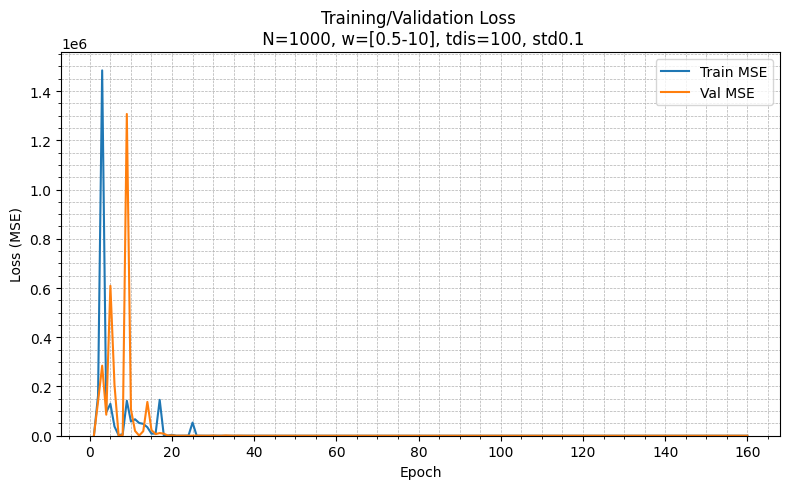

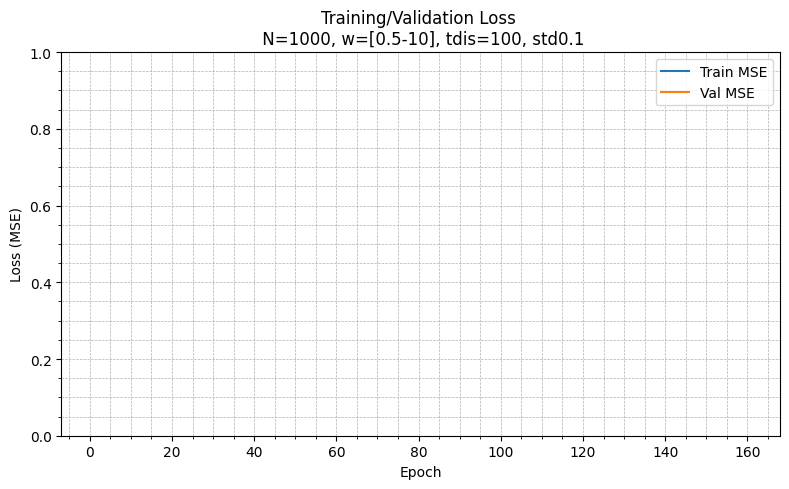

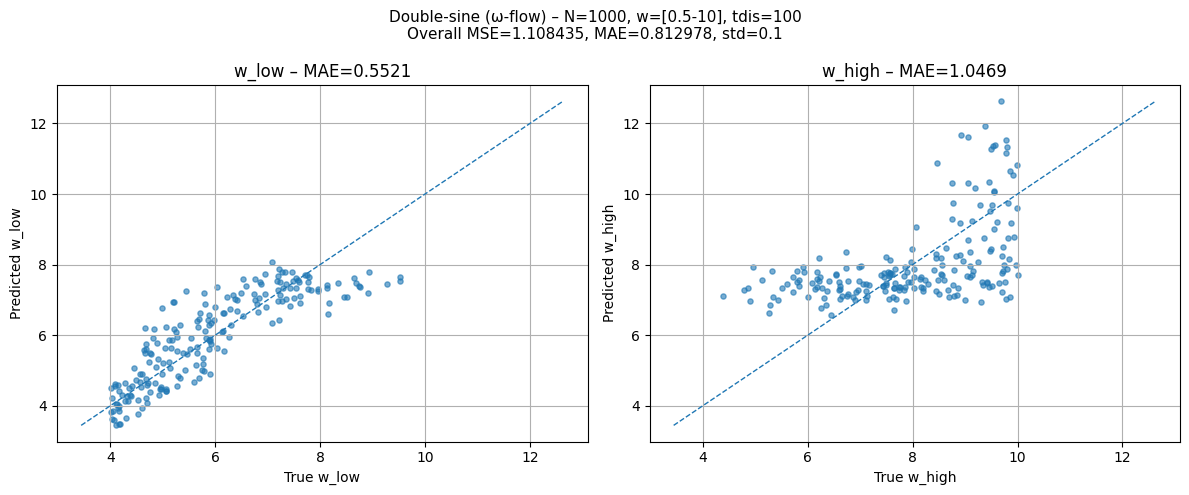

In [14]:
#plotting data collection
y_true, y_pred = prediction_collecter_omegas(test_loader, model, device)

#plots - save or show option
#plot_pred_vs_true(y_true, y_pred, test_mse, test_mae, save_plot=False, show_plot=True)
plot_loss_curves(train_mse_hist, val_mse_hist, save_plot=False, show_plot=True)
plot_loss_curves(train_mse_hist, val_mse_hist, save_plot=False, show_plot=True, y_limit=1, zoom='0.025')

# plots: scatter + loss curves
plot_pred_vs_true_omega(y_true, y_pred, test_mse, test_mae, save_plot=False, show_plot=True)